In [2]:
# Importing important packages
import pickle
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers
from sklearn.neighbors import NearestNeighbors

2026-02-12 14:08:35.952009: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-12 14:08:35.970611: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-12 14:08:36.622629: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Import Signal and label Data

In [3]:
# load signal data
Path = "/home/student/Prathamesh's Project Pre-requisites/CodeSpace/DL/CheckPoint1/"
signal_files = ["/X_TRAIN.pkl","/X_TEST.pkl","/X_VAL.pkl",]

x_train = list()
x_test = list()
x_val = list()

for i in signal_files:
    if i == "/X_TRAIN.pkl":
        with open(Path + "/X_TRAIN.pkl", "rb") as f:
            x_train = pickle.load(f)
    elif i == "/X_TEST.pkl":
        with open(Path + "/X_TEST.pkl", "rb") as f:
            x_test = pickle.load(f)
    elif i == "/X_VAL.pkl":
        with open(Path + "/X_VAL.pkl", "rb") as f:
            x_val = pickle.load(f)

# convert to from np arrays to tensors
x_train = tf.convert_to_tensor(x_train, dtype = tf.float32)
x_test = tf.convert_to_tensor(x_test, dtype = tf.float32)
x_val = tf.convert_to_tensor(x_val, dtype = tf.float32)

In [4]:
# Verify shapes
print(f"The shapes are:\n- x_train is {x_train.shape} \n- x_test is {x_test.shape} \n- x_val is {x_val.shape}")

The shapes are:
- x_train is (12123, 1000, 12) 
- x_test is (1512, 1000, 12) 
- x_val is (1479, 1000, 12)


In [5]:
# load label data
Path = "/home/student/Prathamesh's Project Pre-requisites/CodeSpace/DL/CheckPoint1/"
label_files = ["/Y_TRAIN.pkl","/Y_TEST.pkl","/Y_VAL.pkl",]

for i in label_files:
    if i == "/Y_TRAIN.pkl":
        with open(Path + "/Y_TRAIN.pkl", "rb") as f:
            y_train = pickle.load(f)
    elif i == "/Y_TEST.pkl":
        with open(Path + "/Y_TEST.pkl", "rb") as f:
            y_test = pickle.load(f)
    elif i == "/Y_VAL.pkl":
        with open(Path + "/Y_VAL.pkl", "rb") as f:
            y_val = pickle.load(f)

# process labels
def multihot_encode(pd_series_labels):
    # pandas series to list
    list_labels = pd_series_labels.to_list()

    # convert to ragged vector
    ragged_list_labels = tf.ragged.constant(list_labels)

    # setup string lookup and adapt
    str_lookup_layer = layers.StringLookup(output_mode = "multi_hot")
    str_lookup_layer.adapt(ragged_list_labels) 
    multi_hot_labels = str_lookup_layer(ragged_list_labels)

    return multi_hot_labels

# appyl multi hot encoding
y_train = tf.cast(multihot_encode(y_train),dtype = tf.float32)
y_test = tf.cast(multihot_encode(y_test),dtype = tf.float32)
y_val = tf.cast(multihot_encode(y_val),dtype = tf.float32)

In [6]:
# Verify shapes
print(f"The shapes are:\n- y_train is {y_train.shape} \n- y_test is {y_test.shape} \n- y_val is {y_val.shape}")

The shapes are:
- y_train is (12123, 7) 
- y_test is (1512, 7) 
- y_val is (1479, 7)


## Model Creation

In [12]:
# Conv1D+BiLSTM Model

# residual block
def residual_block(x, filters, kernel_size, stride=1):
    shortcut = x
    
    # main path
    x = layers.Conv1D(filters, kernel_size, strides = stride, padding = "same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv1D(filters, kernel_size, strides = stride, padding = "same")(x)
    x = layers.BatchNormalization()(x)

    # skip-connection
    x = layers.Add()([shortcut, x])
    x = layers.Activation("relu")(x)
    return x

# Input layers
InputLayer = layers.Input(shape=(1000, 12))

# 1D-CNN Block 1
x = layers.Conv1D(filters = 32, kernel_size = 3, strides = 1, activation = "relu", padding = "same")(InputLayer)
x = layers.BatchNormalization()(x)
x = layers.MaxPool1D(pool_size = 2)(x) 
x = layers.Dropout(0.3)(x) 

# 1D-CNN Block 2
x = layers.Conv1D(filters = 64, kernel_size = 5, strides = 1, activation = "relu", padding = "same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool1D(pool_size = 2)(x) 
x = layers.Dropout(0.3)(x) 

# 1D-CNN Block 3  
x = layers.Conv1D(filters = 128, kernel_size = 5, strides = 1, activation = "relu", padding = "same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool1D(pool_size = 2)(x) 
x = layers.Dropout(0.3)(x) 

# residual block 1
x = residual_block(x, filters = 128, kernel_size = 3)

# residual block 2
x = residual_block(x, filters = 128, kernel_size = 3)

# Bi-LSTM Block 1
x = layers.Bidirectional(layers.LSTM(units = 128, return_sequences = True))(x)
x = layers.Dropout(0.4)(x)
x = layers.Bidirectional(layers.LSTM(units = 128, return_sequences = False))(x)

# Classification Overhead
x = layers.Dense(units = 128, activation = "relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(units = 64, activation = "relu")(x)
x = layers.Dropout(0.3)(x)
OutputLayer = layers.Dense(units = 7, activation = "sigmoid")(x)

# Model Creation
model = tf.keras.Model(inputs = InputLayer, outputs = OutputLayer, name = "1DCNN_BiLSTM_Z_Model")

In [13]:
# Define custom metrics

# subclass custom Hamming Loss metric (Not using tensorflow addons here; version clash)
@tf.keras.utils.register_keras_serializable()
class HammingLoss(tf.keras.metrics.Metric):

    def __init__(self, name = "Hamming_loss", **kwargs):
        super(HammingLoss, self).__init__(name = name, **kwargs)
        self.total_mismatches = self.add_weight(name = "Total_mismatches", initializer = 'zeros', dtype = tf.float32)
        self.total_labels = self.add_weight(name = "Total_labels", initializer = 'zeros', dtype = tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # caste predictions and targets in tf.float32
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)

        # Calculate mismatches
        mismatches = tf.cast((tf.math.count_nonzero(tf.math.not_equal(y_true, y_pred), axis=-1)), tf.float32)

        # Find number of labels and batch size
        num_label = tf.cast(tf.shape(y_true)[-1], tf.float32) # shape is (rows, columns) and columns = number of elements in array
        batch_size = tf.cast(tf.shape(y_true)[0], tf.float32) # shape is (rows, columns) and rows = batch size per array
        
        # Update number of mismatches and total labels count
        self.total_mismatches.assign_add(tf.reduce_sum(mismatches)) # reduce sum adds all the elements in an array (here, instance)
        self.total_labels.assign_add(batch_size * num_label) # total label count = number of labels x batch size per instance

    def result(self):
        return self.total_mismatches / self.total_labels # Hamming Loss formula
    
    def reset_state(self): # reset atttributes
        self.total_mismatches.assign(0.)
        self.total_labels.assign(0.)

# subclass custom Hamming score metric
@tf.keras.utils.register_keras_serializable()
class HammingScore(tf.keras.metrics.Metric):

    def __init__(self, name = "Hamming_score", **kwargs):
        super(HammingScore, self).__init__(name = name, **kwargs)
        self.total_mismatches = self.add_weight(name = "Total_mismatches", initializer = 'zeros', dtype = tf.float32)
        self.total_labels = self.add_weight(name = "Total_labels", initializer = 'zeros', dtype = tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # caste predictions and targets in tf.float32
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)

        # Calculate mismatches
        mismatches = tf.cast((tf.math.count_nonzero(tf.math.not_equal(y_true, y_pred), axis=-1)), tf.float32)

        # Find number of labels and batch size
        num_label = tf.cast(tf.shape(y_true)[-1], tf.float32) # shape is (rows, columns) and columns = number of elements in array
        batch_size = tf.cast(tf.shape(y_true)[0], tf.float32) # shape is (rows, columns) and rows = batch size per array
        
        # Update number of mismatches and total labels count
        self.total_mismatches.assign_add(tf.reduce_sum(mismatches)) # reduce sum adds all the elements in an array (here, instance)
        self.total_labels.assign_add(batch_size * num_label) # total label count = number of labels x batch size per instance

    def result(self):
        return 1 - (self.total_mismatches / self.total_labels) # Hamming Score = 1 - Hamming loss
    
    def reset_state(self): # reset atttributes
        self.total_mismatches.assign(0.)
        self.total_labels.assign(0.)

In [14]:
# model compilation (loss function and optimiser)
roc_auc = tf.keras.metrics.AUC(curve = "ROC", name = "ROC-AUC")
accuracy = tf.keras.metrics.BinaryAccuracy(name = "Accuracy")
recall = tf.keras.metrics.Recall(name = "Recall", thresholds = 0.35)
precision = tf.keras.metrics.Precision(name = "Precision", thresholds = 0.4)
F2_score = tf.keras.metrics.FBetaScore(name = "F2", beta = 2.0, average = "weighted", threshold = 0.35)

model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 1e-3),
              loss = tf.keras.losses.binary_focal_crossentropy,
              metrics = [accuracy,
                         roc_auc,
                         F2_score,
                         recall,
                         precision,
                         HammingLoss(), HammingScore()])

In [15]:
# get summary
model.summary()

Model: "1DCNN_BiLSTM_Z_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 1000, 12)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_27 (Conv1D)  │ (None, 1000, 32)  │      1,184 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000, 32)  │        128 │ conv1d_27[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_12    │ (None, 500, 32)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 500, 32)   │          0 │ max_pooling1d_12… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 500, 64)   │     10,304 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 500, 64)   │        256 │ conv1d_28[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_13    │ (None, 250, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 250, 64)   │          0 │ max_pooling1d_13… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 250, 128)  │     41,088 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 250, 128)  │        512 │ conv1d_29[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_14    │ (None, 125, 128)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 125, 128)  │          0 │ max_pooling1d_14… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_30 (Conv1D)  │ (None, 125, 128)  │     49,280 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 128)  │        512 │ conv1d_30[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 125, 128)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 125, 128)  │     49,280 │ activation_13[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 128)  │        512 │ conv1d_31[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 951,655 (3.63 MB)

 Trainable params: 950,183 (3.62 MB)

 Non-trainable params: 1,472 (5.75 KB)

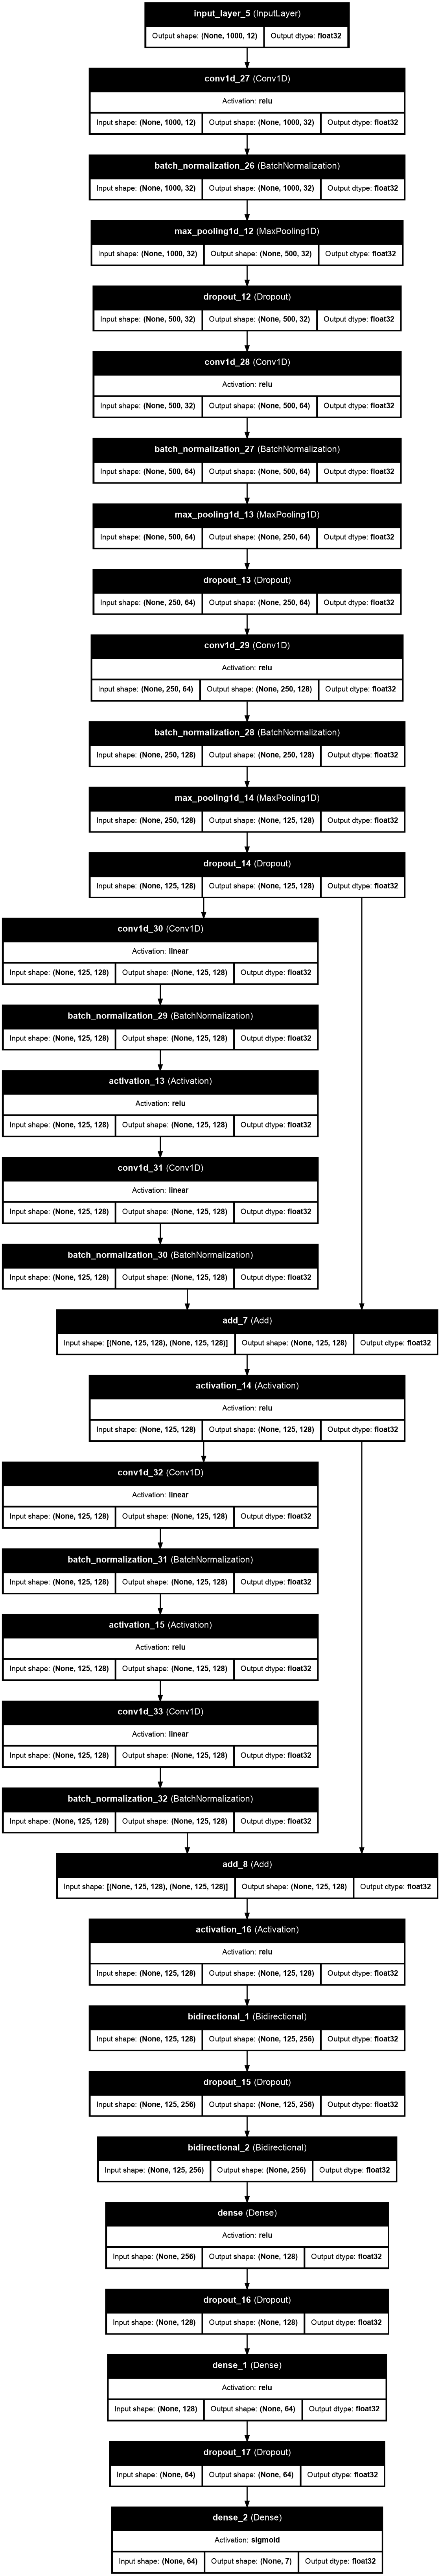

In [16]:
# visualise model
tf.keras.utils.plot_model(model,
                          dpi = 100,
                          to_file = 'Final_Z.png',
                          show_shapes = True,
                          show_dtype = True,
                          show_layer_names = True,
                          show_layer_activations = True)

## Trail Runs

In [17]:
# set callbacks
Callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor = "val_Precision", patience = 12, restore_best_weights = True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 5)
]

In [18]:
# train  model
History = model.fit(
    x = x_train,
    y = y_train,
    validation_data =(x_val, y_val),
    epochs = 100,
    batch_size = 32,
    callbacks = Callbacks
)

Epoch 1/100
379/379 ━━━━━━━━━━━━━━━━━━━━ 41s 99ms/step - Accuracy: 0.8090 - F2: 0.6078 - Hamming_loss: 0.1910 - Hamming_score: 0.8090 - Precision: 0.3200 - ROC-AUC: 0.7411 - Recall: 0.8372 - loss: 0.1092 - val_Accuracy: 0.8166 - val_F2: 0.6218 - val_Hamming_loss: 0.1834 - val_Hamming_score: 0.8166 - val_Precision: 0.2982 - val_ROC-AUC: 0.7674 - val_Recall: 0.9042 - val_loss: 0.1028 - learning_rate: 0.0010
Epoch 2/100
379/379 ━━━━━━━━━━━━━━━━━━━━ 40s 105ms/step - Accuracy: 0.8143 - F2: 0.6182 - Hamming_loss: 0.1857 - Hamming_score: 0.8143 - Precision: 0.3413 - ROC-AUC: 0.7611 - Recall: 0.8788 - loss: 0.1045 - val_Accuracy: 0.8166 - val_F2: 0.6218 - val_Hamming_loss: 0.1834 - val_Hamming_score: 0.8166 - val_Precision: 0.3494 - val_ROC-AUC: 0.7681 - val_Recall: 0.9042 - val_loss: 0.1023 - learning_rate: 0.0010
Epoch 3/100
379/379 ━━━━━━━━━━━━━━━━━━━━ 40s 105ms/step - Accuracy: 0.8137 - F2: 0.6203 - Hamming_loss: 0.1863 - Hamming_score: 0.8137 - Precision: 0.3525 - ROC-AUC: 0.7642 - Recall

In [13]:
# evaluate model
Evaluation_result = model.evaluate(
    x = x_test,
    y = y_test,
    batch_size = 32)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - Accuracy: 0.8163 - F2: 0.6216 - Hamming_loss: 0.1837 - Hamming_score: 0.8163 - Precision: 0.4614 - ROC-AUC: 0.7630 - Recall: 0.9048 - loss: 0.1025


In [14]:
# sample prediction
results = model.predict(x = x_test[99:100])
print(results)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
[[0.06326932 0.48921016 0.3932378  0.38393453 0.38629198 0.27998427
  0.23060854]]
